### Place cell identification pipeline 2.0

In [8]:
def arena_binned(x, y, xdim, ydim, pix_cm, pf_cm):
    d_x = xdim[0] - xdim[1] # xdim[0] = max, xdim[1] = min
    d_y = ydim[0] - ydim[1] # ydim[0] = max, ydim[1] = min
    nBnx = int((d_x/(pix_cm*pf_cm)))
    nBny = int((d_y/(pix_cm*pf_cm)))
    bn_x = [int(i) for i in np.linspace(xdim[0],xdim[1],nBnx)]
    bn_y = [int(i) for i in np.linspace(ydim[0], ydim[1],nBny)]

    bx = ((x-bn_x[0])/(bn_x[1]-bn_x[0])).astype(int)
    by = ((y-bn_y[0])/(bn_y[1]-bn_y[0])).astype(int)
    S = np.vstack((bx,by))
    linS = np.ravel_multi_index(S,(nBnx,nBny))
    occMap = sps.csr_matrix((np.ones(len(bx)),(bx,by)),shape=(nBnx,nBny),dtype=float).todense()
    return linS.astype(float), occMap, nBnx, nBny, bx, by


def bursting_check(linSpf, linS, e_trace, tr_delay):
    #Place field timestamps
    pft_idxs = [i for i in range(len(linS)) if linS[i] in linSpf]
  
    #Seperate timestamps into traverals
    tr_idxs_all = []; tr_idxs = []
    i = 0
    while i < len(pft_idxs)-1:
        tr = pft_idxs[i+1]-pft_idxs[i]
        tr_idxs.append(pft_idxs[i])

        if tr > tr_delay: #acceptable delay between traversals
            tr_idxs_all.append(tr_idxs)
            tr_idxs = []
        i += 1
        
    #Calculate the number of traversals with events
    tr = 0
    for i in tr_idxs_all:
        n_events = sum(e_trace[i])
        if n_events > 0:
            tr += 1
            
    return tr,(tr/len(tr_idxs_all))*100

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sps
from scipy.ndimage import gaussian_filter
from sklearn.feature_selection import mutual_info_regression as mi_skl
import seaborn as sns
from scipy import stats
import time
from matplotlib import gridspec

#------------------------------------------------------
#SELECT DATA
directory = r'E:\Python'
animal = 'H1' # set animal
session = 'A1' # set session
stage = 'PRE' # set stage

#SELECT DIRECTORY TO SAVE RESULTS & FIGURES
save_to = directory

# PLACE CELL INCLUSION CRITERIA
n_events = 3 # CONDITION 1: set n events for a cell to be considered
perc_thresh = 99 # CONDITION 2: Set place cell spatial info percentile 
n_tr = 3 # CONDITION 3: set number of traversals to be considered
tr_thresh = 20 # CONDITION 4: % traversals that cell fires <-- accounts for rdm bursting

#ADDITIONAL PARAMS
xdim = [745, -155] # Set arena x dimensions
ydim = [756,-155] # Set Arena y dimensions
pix_cm = 5 # Set how many pixels = 1 cm
pf_cm = 4 # Set bin size for place field (cms)
shuffles = 500 # set number of shuffles to create SI distribution
tr_delay = 40 # acceptable delay between traversals (frames)
#------------------------------------------------------

#Read in aligned events df
file = 'H1_A1_PRE_event_dlc_fake.csv'
meta = pd.read_csv(directory,file)
meta = meta.loc[(meta['Session']==session) & (meta['Stage']==stage)]


<ipython-input-11-6fcd7f8b8409>:39: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  meta = pd.read_csv(directory,file)


PermissionError: [Errno 13] Permission denied: 'E:\\Python'

In [ ]:
meta

In [ ]:

a_meta = meta

#Only analyse moving points # INCLUDE SPEED FUNCTION HERE
mov_meta = a_meta[a_meta['Movement status']=='moving']
x = mov_meta['cap_x'].values.astype(float)
y = mov_meta['cap_y'].values.astype(float)

#Bin and linearize occupancy
linS, occMap, nBnx, nBny, bx, by = arena_binned(x = x, y = y,
                                                xdim = xdim, ydim = ydim,
                                                pix_cm = pix_cm, pf_cm = pf_cm)

#Isolate and binarize events
e_traces = mov_meta[mov_meta[[col for col in mov_meta if col.startswith(' C')]]
                    .loc[:,~(mov_meta[[col for col in mov_meta if col.startswith(' C')]] == " nan").any()].columns.values]
cell_IDS = e_traces.columns.values
e_traces[e_traces > 0] = 1 # OPTIONAL: Binarized events
e_traces = e_traces.values.T

criteria = np.zeros((len(e_traces),4));
pcs = []; Percs = []; SI =[]
for i, ev in enumerate(e_traces):
    print(i+1,'/',len(cell_IDS))
    
    #Calculate place map
    rateMap = sps.csr_matrix((ev,(bx,by)),shape=(nBnx,nBny),dtype=float).todense()
    placeMap = np.divide(rateMap,occMap); placeMap[np.isnan(placeMap)] = 0
    
    #CONDITION 1: Exclude cells that have less than n events
    if  len([e for e in ev if e > 0]) > n_events:
        criteria[i][0] = int(1)
        
        #Calculate SI and compare to distribution
        res_eve = list(np.array(ev.reshape(-1,1)).astype(float))
        si = mi_skl(res_eve, linS, discrete_features=True,n_neighbors=3)
        SI.append(si)
        
        #Create distribution of SI with shuffled events
        si_shuf = []
        for s in range(shuffles): 
            np.random.shuffle(res_eve)
            si_shuf.append(mi_skl(res_eve, linS, discrete_features=True,n_neighbors=3))
            if s > 0 and s % 1000 == 0:
                print(s, 'shuffles completed')
        
        #Calculate percentile
        perc = stats.percentileofscore(si_shuf, si)
        Percs.append(perc)
        
        #Account for n traversalss random bursting cells
        s_placeMap = gaussian_filter(placeMap, sigma = 1)
        sn_placeMap = np.array(s_placeMap)/np.max(s_placeMap)
        sn_placeMap[sn_placeMap < 0.2] = 0
        pf_idxs = np.argwhere(sn_placeMap > 0)
        S_pf = np.vstack((pf_idxs[:,0],pf_idxs[:,1]))
        linSpf = np.ravel_multi_index(S_pf,(nBnx,nBny))
        tr, rdm_burst = bursting_check(linSpf, linS, ev, tr_delay)
        
        # CONDITION 2: cell SI > Threshold are considered a Place cell
        if perc >= perc_thresh:
            criteria[i][1] = int(1)
                      
        #CONDITION 3: Number of traversals required   
        if tr > n_tr: 
            criteria[i][2] = int(1)
            
        #CONDITION 4: number of traversals with cell firing  
        if rdm_burst >= tr_thresh: 
            criteria[i][3] = int(1)
        
        #If all place cell criteria, then place cell identified
        if sum(criteria[i]) == 4:
            print(cell_IDS[i], 'Is a place cell with %d traversals' %tr)
            pcs.append(1)
        else:
            pcs.append(0)         
    else:
        pcs.append(0)
        SI.append(0)
        Percs.append(0)

print(sum(pcs), 'out of %d cells have been identified as place cells' %len(pcs))
print((sum(pcs)/len(pcs))*100, ' Percent of cells are place cells')


<ipython-input-70-370943d2d8c8>:6: RuntimeWarning: invalid value encountered in true_divide
  placeMap = np.divide(rateMap,occMap); placeMap[np.isnan(placeMap)] = 0


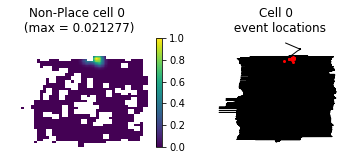

<ipython-input-70-370943d2d8c8>:6: RuntimeWarning: invalid value encountered in true_divide
  placeMap = np.divide(rateMap,occMap); placeMap[np.isnan(placeMap)] = 0


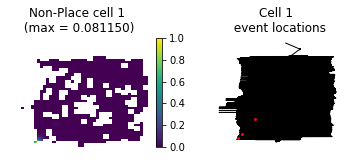

<ipython-input-70-370943d2d8c8>:6: RuntimeWarning: invalid value encountered in true_divide
  placeMap = np.divide(rateMap,occMap); placeMap[np.isnan(placeMap)] = 0
<ipython-input-70-370943d2d8c8>:10: RuntimeWarning: invalid value encountered in true_divide
  pc_plot = pc_plot/max_pc_plot


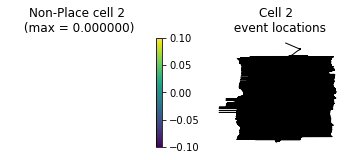

<ipython-input-70-370943d2d8c8>:6: RuntimeWarning: invalid value encountered in true_divide
  placeMap = np.divide(rateMap,occMap); placeMap[np.isnan(placeMap)] = 0


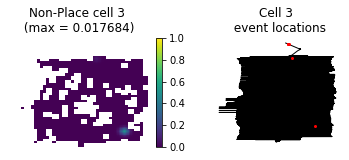

<ipython-input-70-370943d2d8c8>:6: RuntimeWarning: invalid value encountered in true_divide
  placeMap = np.divide(rateMap,occMap); placeMap[np.isnan(placeMap)] = 0


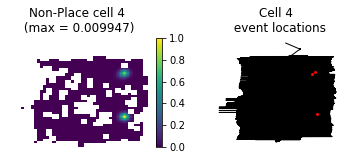

<ipython-input-70-370943d2d8c8>:6: RuntimeWarning: invalid value encountered in true_divide
  placeMap = np.divide(rateMap,occMap); placeMap[np.isnan(placeMap)] = 0


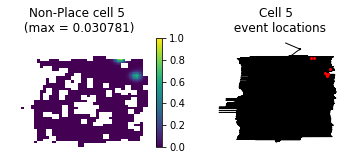

In [70]:
placeMaps = []
occ_nan = np.argwhere(occMap == 0)
for i, ev in enumerate(e_traces):
    #Calculate rate and place map
    rateMap = sps.csr_matrix((ev,(bx,by)),shape=(nBnx,nBny),dtype=float).todense()
    placeMap = np.divide(rateMap,occMap); placeMap[np.isnan(placeMap)] = 0
    placeMaps.append(placeMap)
    pc_plot = gaussian_filter(np.array(placeMap), sigma = 1)
    max_pc_plot = np.max(pc_plot)
    pc_plot = pc_plot/max_pc_plot
    pc_plot[np.ix_(occ_nan[:,0]),occ_nan[:,1]] = np.nan
    
    e_idxs = [e_i for e_i, e in enumerate(ev) if e > 0]
    x_e = x[e_idxs]; y_e = y[e_idxs]

    if pcs[i]==1: # plot place cells
        #Plot smoother & normalized place field
        fig = plt.figure(figsize=(6,2))
        gs = gridspec.GridSpec(1, 2, width_ratios=[3, 2.2]) 
        ax0 = plt.subplot(gs[0])
        plt.imshow(pc_plot.T,aspect="auto")
        plt.colorbar()
        plt.gca().invert_xaxis()
        plt.gca().invert_yaxis()
        sns.despine()
        plt.axis('off')
        plt.title('Place cell '+str(i)+'\n (max = %3f)'%max_pc_plot)
        
        #Plot event overlays
        ax1 = plt.subplot(gs[1])
        plt.plot(x, y, c = 'k', linewidth = 1, zorder = 0)
        plt.scatter(x_e, y_e, s = 4, c = 'r', zorder = 1)
        plt.gca().invert_yaxis()
        plt.axis('off')
        plt.title('Cell '+str(i)+'event locations')
        plt.savefig(save_to + 'Place cell '+str(i)+'.jpeg', dpi=300)
        plt.show()
    else:
        #Plot smoother & normalized place field
        fig = plt.figure(figsize=(6,2))
        gs = gridspec.GridSpec(1, 2, width_ratios=[3, 2.2]) 
        ax0 = plt.subplot(gs[0])
        plt.imshow(pc_plot.T,aspect="auto")
        plt.colorbar()
        plt.gca().invert_xaxis()
        plt.gca().invert_yaxis()
        sns.despine()
        plt.axis('off')
        plt.title('Non-Place cell '+str(i)+'\n (max = %3f)'%max_pc_plot)
        
        #Plot event overlays
        ax1 = plt.subplot(gs[1])
        plt.plot(x, y, c = 'k', linewidth = 1, zorder = 0)
        plt.scatter(x_e, y_e, s = 4, c = 'r', zorder = 1)
        plt.gca().invert_yaxis()
        plt.axis('off')
        plt.title('Cell '+str(i)+' \n event locations')
        plt.savefig(save_to + 'non-place cell '+str(i)+'.jpeg', dpi=300)
        plt.show()
        

new_meta = pd.DataFrame({'Cell IDS':cell_IDS,'Place cells':pcs,
                         'Criteria':list(criteria),'SI':SI,
                         'Percentile':Percs,})

new_meta.to_csv(save_to + str(animal)+'_'+str(session)+'_'+str(stage)+'_place_cells.csv', index=False)

In [ ]:
#idea
for i in range
    if ['direction']=0
        df['MI_N']=df.apply(place_cell_function) #?
        
#or

for i in range
    for row in df['direction'=0]
        df.loc[row, 'MI_N']=place_cell_function(row, df) #maybe something like that
    for row in df['direction'=1]
         df.loc[row, 'MI_W']=place_cell_function(row, df) #etc